# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
# data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

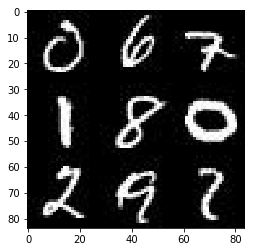

In [2]:
show_n_images = 9

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

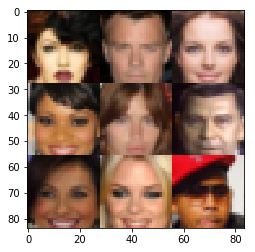

In [3]:
show_n_images = 9

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], "input_real")
    input_z = tf.placeholder(tf.float32, [None, z_dim], "input_z")
    learning_rate = tf.placeholder(tf.float32, None, "learning_rate")

    return input_real, input_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False, alpha=0.01):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    leaky_relu = lambda x: tf.maximum(alpha * x, x)
    
    def conv(inputs, filters, batch_norm=True):
        outputs = tf.layers.conv2d(inputs, filters, 5, 2, 'same')
        if batch_norm:
            outputs = tf.layers.batch_normalization(outputs, training=True)
        return leaky_relu(outputs)
    
    with tf.variable_scope("discriminator", reuse=reuse):
        # input 28*28*3
        x1 = conv(images, 64, batch_norm=False) # 14*14*64
        x2 = conv(x1, 128) # 7*7*128
        x3 = conv(x2, 256) # 4*4*256
        
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.01):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    leaky_relu = lambda x: tf.maximum(alpha * x, x)
    with tf.variable_scope("generator", reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = leaky_relu(x1)
        # 7*7*512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, 1, 'SAME')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = leaky_relu(x2)
        # 7*7*256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, 2, 'SAME')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = leaky_relu(x3)
        # 14*14*128
    
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, 2, 'SAME')
        out = tf.tanh(logits)
        # 28*28*out_channel_dim
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.9):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * alpha))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    with tf.control_dependencies(update_ops):
        t_vars = tf.trainable_variables()
        
        d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
        g_vars = [var for var in t_vars if var.name.startswith('generator')]

        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

        return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)

    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])

    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                steps +=1
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % 25 == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Batch {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, show_n_images, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Batch 25... Discriminator Loss: 0.4408... Generator Loss: 10.3398
Epoch 1/2... Batch 50... Discriminator Loss: 0.7110... Generator Loss: 1.4364
Epoch 1/2... Batch 75... Discriminator Loss: 1.1369... Generator Loss: 1.1975
Epoch 1/2... Batch 100... Discriminator Loss: 1.0483... Generator Loss: 1.9711


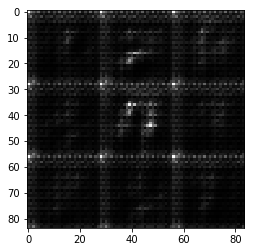

Epoch 1/2... Batch 125... Discriminator Loss: 1.0836... Generator Loss: 1.7889
Epoch 1/2... Batch 150... Discriminator Loss: 1.3810... Generator Loss: 0.6911
Epoch 1/2... Batch 175... Discriminator Loss: 1.0400... Generator Loss: 1.2176
Epoch 1/2... Batch 200... Discriminator Loss: 1.2414... Generator Loss: 0.7282


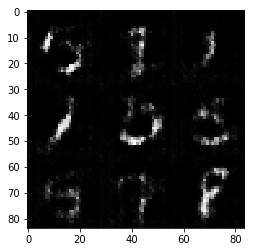

Epoch 1/2... Batch 225... Discriminator Loss: 1.4466... Generator Loss: 0.5508
Epoch 1/2... Batch 250... Discriminator Loss: 1.3808... Generator Loss: 0.6305
Epoch 1/2... Batch 275... Discriminator Loss: 1.2767... Generator Loss: 0.6252
Epoch 1/2... Batch 300... Discriminator Loss: 1.2242... Generator Loss: 0.6812


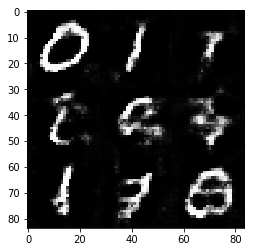

Epoch 1/2... Batch 325... Discriminator Loss: 1.4843... Generator Loss: 0.4383
Epoch 1/2... Batch 350... Discriminator Loss: 1.0397... Generator Loss: 0.8858
Epoch 1/2... Batch 375... Discriminator Loss: 1.6003... Generator Loss: 0.4012
Epoch 1/2... Batch 400... Discriminator Loss: 1.1589... Generator Loss: 0.7771


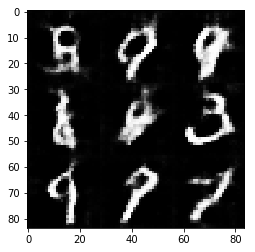

Epoch 1/2... Batch 425... Discriminator Loss: 1.5122... Generator Loss: 2.0285
Epoch 1/2... Batch 450... Discriminator Loss: 1.1479... Generator Loss: 0.8889
Epoch 1/2... Batch 475... Discriminator Loss: 1.1351... Generator Loss: 1.3519
Epoch 1/2... Batch 500... Discriminator Loss: 1.1164... Generator Loss: 1.0542


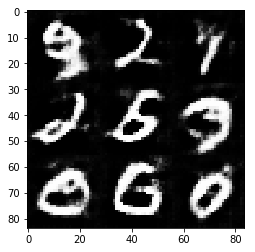

Epoch 1/2... Batch 525... Discriminator Loss: 1.2112... Generator Loss: 0.7628
Epoch 1/2... Batch 550... Discriminator Loss: 1.1587... Generator Loss: 1.3278
Epoch 1/2... Batch 575... Discriminator Loss: 1.2044... Generator Loss: 0.8260
Epoch 1/2... Batch 600... Discriminator Loss: 1.3818... Generator Loss: 0.5258


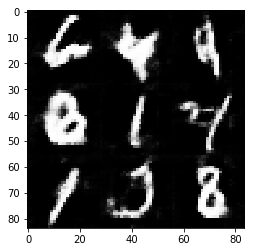

Epoch 1/2... Batch 625... Discriminator Loss: 1.4383... Generator Loss: 0.5060
Epoch 1/2... Batch 650... Discriminator Loss: 1.4321... Generator Loss: 0.5055
Epoch 1/2... Batch 675... Discriminator Loss: 1.1395... Generator Loss: 0.9243
Epoch 1/2... Batch 700... Discriminator Loss: 1.1430... Generator Loss: 0.8499


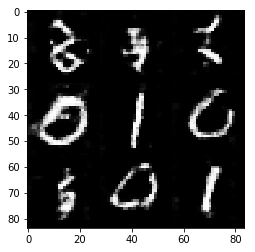

Epoch 1/2... Batch 725... Discriminator Loss: 1.0739... Generator Loss: 0.9957
Epoch 1/2... Batch 750... Discriminator Loss: 1.6264... Generator Loss: 0.3862
Epoch 1/2... Batch 775... Discriminator Loss: 1.0305... Generator Loss: 1.0525
Epoch 1/2... Batch 800... Discriminator Loss: 1.2631... Generator Loss: 0.9612


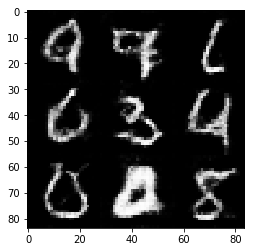

Epoch 1/2... Batch 825... Discriminator Loss: 1.1397... Generator Loss: 0.7362
Epoch 1/2... Batch 850... Discriminator Loss: 1.4718... Generator Loss: 0.4900
Epoch 1/2... Batch 875... Discriminator Loss: 1.0597... Generator Loss: 1.0268
Epoch 1/2... Batch 900... Discriminator Loss: 1.1597... Generator Loss: 1.4092


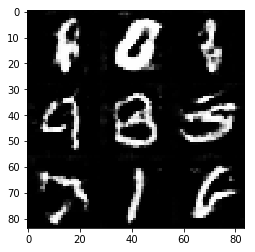

Epoch 1/2... Batch 925... Discriminator Loss: 1.0562... Generator Loss: 0.9219
Epoch 2/2... Batch 25... Discriminator Loss: 1.0776... Generator Loss: 1.1015
Epoch 2/2... Batch 50... Discriminator Loss: 1.3317... Generator Loss: 0.5718
Epoch 2/2... Batch 75... Discriminator Loss: 1.0552... Generator Loss: 1.7641
Epoch 2/2... Batch 100... Discriminator Loss: 1.2480... Generator Loss: 2.4270


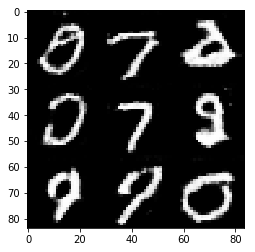

Epoch 2/2... Batch 125... Discriminator Loss: 1.2092... Generator Loss: 0.7036
Epoch 2/2... Batch 150... Discriminator Loss: 0.8842... Generator Loss: 1.0914
Epoch 2/2... Batch 175... Discriminator Loss: 1.1080... Generator Loss: 0.7815
Epoch 2/2... Batch 200... Discriminator Loss: 1.1306... Generator Loss: 0.8128


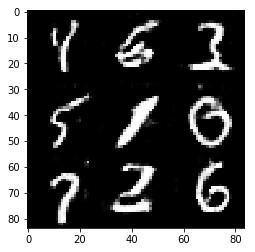

Epoch 2/2... Batch 225... Discriminator Loss: 0.8179... Generator Loss: 1.3997
Epoch 2/2... Batch 250... Discriminator Loss: 0.8673... Generator Loss: 1.1342
Epoch 2/2... Batch 275... Discriminator Loss: 0.9645... Generator Loss: 0.9632
Epoch 2/2... Batch 300... Discriminator Loss: 0.8852... Generator Loss: 1.3674


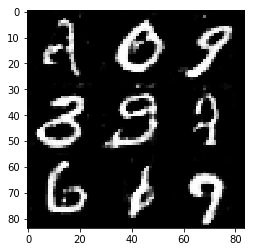

Epoch 2/2... Batch 325... Discriminator Loss: 0.7961... Generator Loss: 1.4859
Epoch 2/2... Batch 350... Discriminator Loss: 1.2409... Generator Loss: 0.6664
Epoch 2/2... Batch 375... Discriminator Loss: 1.1952... Generator Loss: 0.6865
Epoch 2/2... Batch 400... Discriminator Loss: 1.0161... Generator Loss: 1.0108


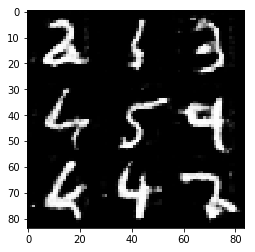

Epoch 2/2... Batch 425... Discriminator Loss: 0.8484... Generator Loss: 1.1357
Epoch 2/2... Batch 450... Discriminator Loss: 1.9067... Generator Loss: 3.3961
Epoch 2/2... Batch 475... Discriminator Loss: 0.8430... Generator Loss: 1.6544
Epoch 2/2... Batch 500... Discriminator Loss: 2.2804... Generator Loss: 3.6864


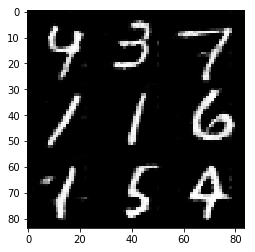

Epoch 2/2... Batch 525... Discriminator Loss: 0.9199... Generator Loss: 0.9924
Epoch 2/2... Batch 550... Discriminator Loss: 0.9258... Generator Loss: 2.0806
Epoch 2/2... Batch 575... Discriminator Loss: 1.0900... Generator Loss: 0.7953
Epoch 2/2... Batch 600... Discriminator Loss: 2.6100... Generator Loss: 0.1666


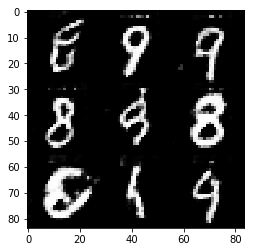

Epoch 2/2... Batch 625... Discriminator Loss: 0.7147... Generator Loss: 1.7130
Epoch 2/2... Batch 650... Discriminator Loss: 1.1650... Generator Loss: 0.6728
Epoch 2/2... Batch 675... Discriminator Loss: 3.1879... Generator Loss: 0.1458
Epoch 2/2... Batch 700... Discriminator Loss: 0.9816... Generator Loss: 0.9744


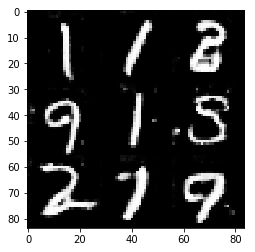

Epoch 2/2... Batch 725... Discriminator Loss: 0.7711... Generator Loss: 1.9212
Epoch 2/2... Batch 750... Discriminator Loss: 0.8317... Generator Loss: 1.2463
Epoch 2/2... Batch 775... Discriminator Loss: 0.8724... Generator Loss: 1.5197
Epoch 2/2... Batch 800... Discriminator Loss: 0.8995... Generator Loss: 1.0011


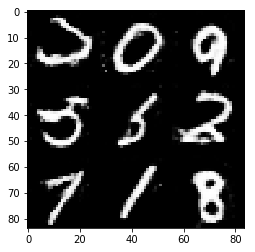

Epoch 2/2... Batch 825... Discriminator Loss: 0.9345... Generator Loss: 1.0602
Epoch 2/2... Batch 850... Discriminator Loss: 0.8104... Generator Loss: 1.3752
Epoch 2/2... Batch 875... Discriminator Loss: 1.0477... Generator Loss: 0.9053
Epoch 2/2... Batch 900... Discriminator Loss: 0.8284... Generator Loss: 1.9766


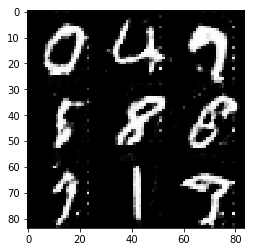

Epoch 2/2... Batch 925... Discriminator Loss: 1.1694... Generator Loss: 2.3746


In [12]:
batch_size = 64 # not 128 due to GPU memory limitations
z_dim = 128
learning_rate = 0.0005
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Batch 25... Discriminator Loss: 0.8550... Generator Loss: 1.1041
Epoch 1/1... Batch 50... Discriminator Loss: 1.4040... Generator Loss: 7.9555
Epoch 1/1... Batch 75... Discriminator Loss: 0.6799... Generator Loss: 2.2933
Epoch 1/1... Batch 100... Discriminator Loss: 1.1198... Generator Loss: 0.9035


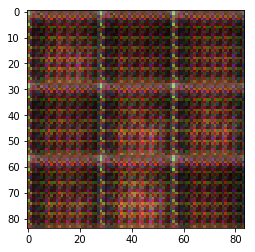

Epoch 1/1... Batch 125... Discriminator Loss: 0.7580... Generator Loss: 1.4724
Epoch 1/1... Batch 150... Discriminator Loss: 0.6797... Generator Loss: 2.0668
Epoch 1/1... Batch 175... Discriminator Loss: 0.7873... Generator Loss: 2.0917
Epoch 1/1... Batch 200... Discriminator Loss: 1.0790... Generator Loss: 1.0854


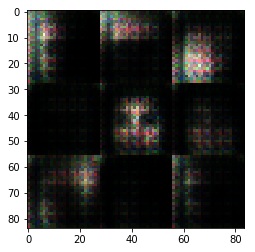

Epoch 1/1... Batch 225... Discriminator Loss: 0.8781... Generator Loss: 1.5343
Epoch 1/1... Batch 250... Discriminator Loss: 0.8260... Generator Loss: 1.7419
Epoch 1/1... Batch 275... Discriminator Loss: 1.0487... Generator Loss: 1.4030
Epoch 1/1... Batch 300... Discriminator Loss: 1.7045... Generator Loss: 0.3635


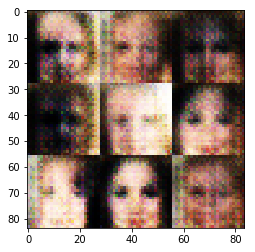

Epoch 1/1... Batch 325... Discriminator Loss: 1.0827... Generator Loss: 1.0795
Epoch 1/1... Batch 350... Discriminator Loss: 1.0484... Generator Loss: 2.1179
Epoch 1/1... Batch 375... Discriminator Loss: 0.9467... Generator Loss: 1.2190
Epoch 1/1... Batch 400... Discriminator Loss: 0.9729... Generator Loss: 1.1115


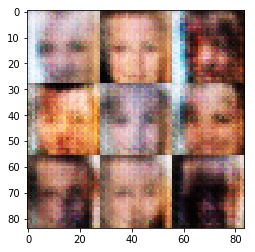

Epoch 1/1... Batch 425... Discriminator Loss: 1.1619... Generator Loss: 0.8404
Epoch 1/1... Batch 450... Discriminator Loss: 1.1994... Generator Loss: 0.8152
Epoch 1/1... Batch 475... Discriminator Loss: 0.9072... Generator Loss: 1.1068
Epoch 1/1... Batch 500... Discriminator Loss: 1.2502... Generator Loss: 0.7609


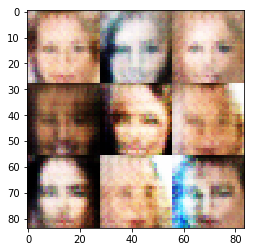

Epoch 1/1... Batch 525... Discriminator Loss: 1.6004... Generator Loss: 0.4198
Epoch 1/1... Batch 550... Discriminator Loss: 0.5868... Generator Loss: 3.2600
Epoch 1/1... Batch 575... Discriminator Loss: 1.2985... Generator Loss: 2.3726
Epoch 1/1... Batch 600... Discriminator Loss: 1.1663... Generator Loss: 0.7448


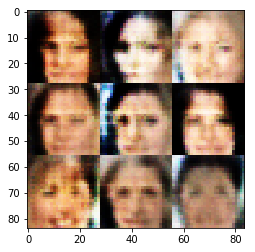

Epoch 1/1... Batch 625... Discriminator Loss: 1.0855... Generator Loss: 0.8493
Epoch 1/1... Batch 650... Discriminator Loss: 0.9215... Generator Loss: 3.3734
Epoch 1/1... Batch 675... Discriminator Loss: 0.8921... Generator Loss: 1.2911
Epoch 1/1... Batch 700... Discriminator Loss: 1.0527... Generator Loss: 0.8890


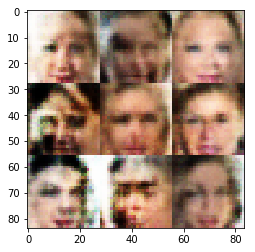

Epoch 1/1... Batch 725... Discriminator Loss: 0.8140... Generator Loss: 1.6701
Epoch 1/1... Batch 750... Discriminator Loss: 1.9496... Generator Loss: 0.2936
Epoch 1/1... Batch 775... Discriminator Loss: 0.7972... Generator Loss: 1.2122
Epoch 1/1... Batch 800... Discriminator Loss: 2.0757... Generator Loss: 0.2595


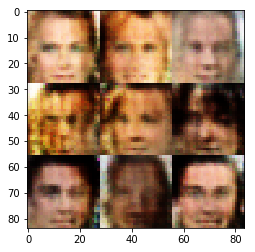

Epoch 1/1... Batch 825... Discriminator Loss: 0.6682... Generator Loss: 2.0429
Epoch 1/1... Batch 850... Discriminator Loss: 1.1304... Generator Loss: 0.7821
Epoch 1/1... Batch 875... Discriminator Loss: 1.2131... Generator Loss: 0.7017
Epoch 1/1... Batch 900... Discriminator Loss: 1.2619... Generator Loss: 0.6396


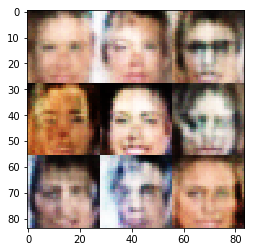

Epoch 1/1... Batch 925... Discriminator Loss: 1.4286... Generator Loss: 0.5225
Epoch 1/1... Batch 950... Discriminator Loss: 1.3050... Generator Loss: 0.7188
Epoch 1/1... Batch 975... Discriminator Loss: 0.9310... Generator Loss: 2.2842
Epoch 1/1... Batch 1000... Discriminator Loss: 0.7156... Generator Loss: 1.9062


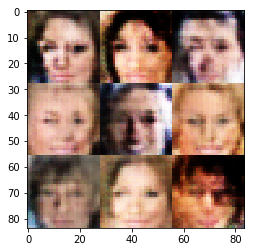

Epoch 1/1... Batch 1025... Discriminator Loss: 0.6806... Generator Loss: 1.9657
Epoch 1/1... Batch 1050... Discriminator Loss: 1.2427... Generator Loss: 0.6597
Epoch 1/1... Batch 1075... Discriminator Loss: 0.9887... Generator Loss: 1.9326
Epoch 1/1... Batch 1100... Discriminator Loss: 0.5992... Generator Loss: 2.3525


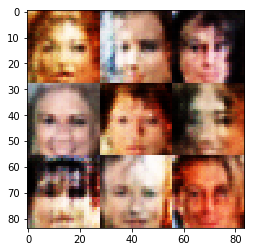

Epoch 1/1... Batch 1125... Discriminator Loss: 1.0619... Generator Loss: 0.9880
Epoch 1/1... Batch 1150... Discriminator Loss: 1.5413... Generator Loss: 0.4388
Epoch 1/1... Batch 1175... Discriminator Loss: 0.8918... Generator Loss: 1.0436
Epoch 1/1... Batch 1200... Discriminator Loss: 1.1949... Generator Loss: 0.8996


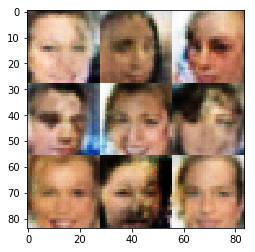

Epoch 1/1... Batch 1225... Discriminator Loss: 0.9077... Generator Loss: 4.5092
Epoch 1/1... Batch 1250... Discriminator Loss: 1.2577... Generator Loss: 0.7935
Epoch 1/1... Batch 1275... Discriminator Loss: 1.3311... Generator Loss: 0.5849
Epoch 1/1... Batch 1300... Discriminator Loss: 1.3316... Generator Loss: 0.6023


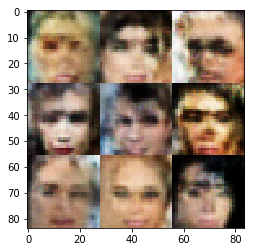

Epoch 1/1... Batch 1325... Discriminator Loss: 0.8461... Generator Loss: 1.4972
Epoch 1/1... Batch 1350... Discriminator Loss: 0.9790... Generator Loss: 1.7608
Epoch 1/1... Batch 1375... Discriminator Loss: 1.1080... Generator Loss: 2.3835
Epoch 1/1... Batch 1400... Discriminator Loss: 1.1391... Generator Loss: 0.7826


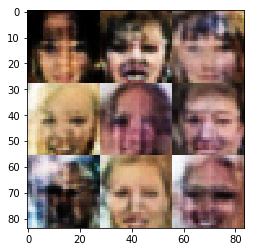

Epoch 1/1... Batch 1425... Discriminator Loss: 0.6710... Generator Loss: 1.6322
Epoch 1/1... Batch 1450... Discriminator Loss: 0.9290... Generator Loss: 1.0865
Epoch 1/1... Batch 1475... Discriminator Loss: 1.0913... Generator Loss: 1.6412
Epoch 1/1... Batch 1500... Discriminator Loss: 1.2493... Generator Loss: 1.1108


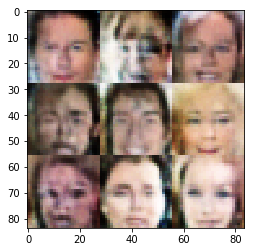

Epoch 1/1... Batch 1525... Discriminator Loss: 0.9433... Generator Loss: 0.9730
Epoch 1/1... Batch 1550... Discriminator Loss: 1.2952... Generator Loss: 0.7901
Epoch 1/1... Batch 1575... Discriminator Loss: 1.1200... Generator Loss: 1.9149
Epoch 1/1... Batch 1600... Discriminator Loss: 0.6913... Generator Loss: 1.4375


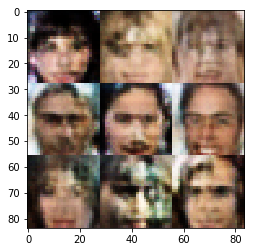

Epoch 1/1... Batch 1625... Discriminator Loss: 0.9287... Generator Loss: 2.2131
Epoch 1/1... Batch 1650... Discriminator Loss: 1.0759... Generator Loss: 0.8792
Epoch 1/1... Batch 1675... Discriminator Loss: 1.2430... Generator Loss: 0.9005
Epoch 1/1... Batch 1700... Discriminator Loss: 1.2456... Generator Loss: 0.6668


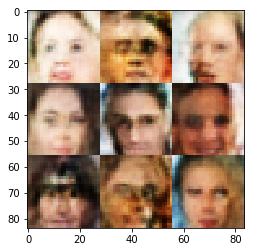

Epoch 1/1... Batch 1725... Discriminator Loss: 1.3338... Generator Loss: 0.5623
Epoch 1/1... Batch 1750... Discriminator Loss: 1.2705... Generator Loss: 1.4952
Epoch 1/1... Batch 1775... Discriminator Loss: 0.9248... Generator Loss: 1.5482
Epoch 1/1... Batch 1800... Discriminator Loss: 1.5046... Generator Loss: 0.6400


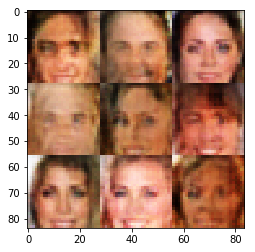

Epoch 1/1... Batch 1825... Discriminator Loss: 1.0986... Generator Loss: 1.0274
Epoch 1/1... Batch 1850... Discriminator Loss: 0.9778... Generator Loss: 1.2017
Epoch 1/1... Batch 1875... Discriminator Loss: 1.2169... Generator Loss: 0.7195
Epoch 1/1... Batch 1900... Discriminator Loss: 1.1649... Generator Loss: 0.7923


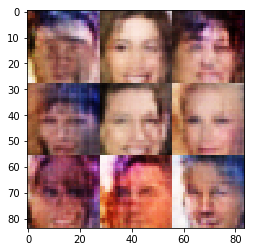

Epoch 1/1... Batch 1925... Discriminator Loss: 1.2092... Generator Loss: 0.7163
Epoch 1/1... Batch 1950... Discriminator Loss: 0.8217... Generator Loss: 1.5684
Epoch 1/1... Batch 1975... Discriminator Loss: 1.4129... Generator Loss: 0.6107
Epoch 1/1... Batch 2000... Discriminator Loss: 2.5110... Generator Loss: 0.1569


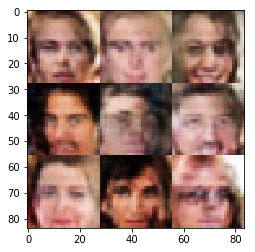

Epoch 1/1... Batch 2025... Discriminator Loss: 1.2099... Generator Loss: 0.7471
Epoch 1/1... Batch 2050... Discriminator Loss: 1.0896... Generator Loss: 1.0516
Epoch 1/1... Batch 2075... Discriminator Loss: 1.5531... Generator Loss: 0.4155
Epoch 1/1... Batch 2100... Discriminator Loss: 1.2508... Generator Loss: 0.8038


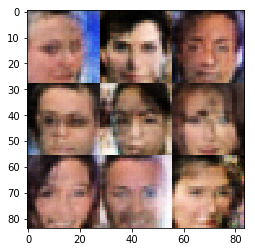

Epoch 1/1... Batch 2125... Discriminator Loss: 1.0846... Generator Loss: 1.0077
Epoch 1/1... Batch 2150... Discriminator Loss: 1.0412... Generator Loss: 0.8593
Epoch 1/1... Batch 2175... Discriminator Loss: 1.6131... Generator Loss: 0.4391
Epoch 1/1... Batch 2200... Discriminator Loss: 0.9152... Generator Loss: 1.1922


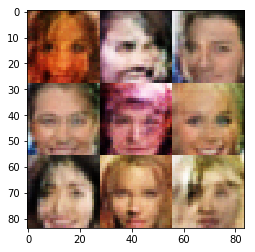

Epoch 1/1... Batch 2225... Discriminator Loss: 1.1752... Generator Loss: 1.2260
Epoch 1/1... Batch 2250... Discriminator Loss: 1.3596... Generator Loss: 0.5644
Epoch 1/1... Batch 2275... Discriminator Loss: 0.9867... Generator Loss: 0.9758
Epoch 1/1... Batch 2300... Discriminator Loss: 0.6571... Generator Loss: 2.4973


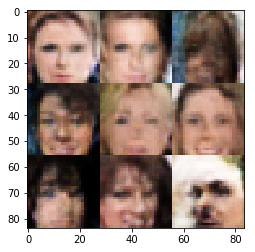

Epoch 1/1... Batch 2325... Discriminator Loss: 1.2887... Generator Loss: 0.6667
Epoch 1/1... Batch 2350... Discriminator Loss: 1.1620... Generator Loss: 0.8062
Epoch 1/1... Batch 2375... Discriminator Loss: 1.4353... Generator Loss: 0.5149
Epoch 1/1... Batch 2400... Discriminator Loss: 1.1193... Generator Loss: 1.1767


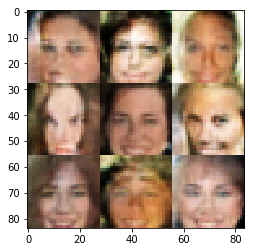

Epoch 1/1... Batch 2425... Discriminator Loss: 0.9162... Generator Loss: 1.2701
Epoch 1/1... Batch 2450... Discriminator Loss: 0.9780... Generator Loss: 1.0019
Epoch 1/1... Batch 2475... Discriminator Loss: 1.1545... Generator Loss: 0.7274
Epoch 1/1... Batch 2500... Discriminator Loss: 1.2216... Generator Loss: 0.8077


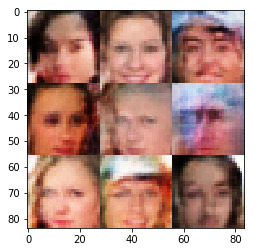

Epoch 1/1... Batch 2525... Discriminator Loss: 0.6526... Generator Loss: 1.8687
Epoch 1/1... Batch 2550... Discriminator Loss: 1.3836... Generator Loss: 0.6350
Epoch 1/1... Batch 2575... Discriminator Loss: 1.2543... Generator Loss: 0.7599
Epoch 1/1... Batch 2600... Discriminator Loss: 1.2363... Generator Loss: 0.7662


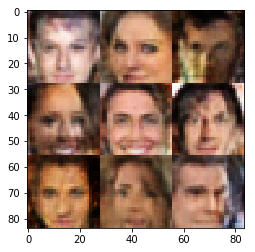

Epoch 1/1... Batch 2625... Discriminator Loss: 1.1304... Generator Loss: 0.8477
Epoch 1/1... Batch 2650... Discriminator Loss: 2.1543... Generator Loss: 0.2101
Epoch 1/1... Batch 2675... Discriminator Loss: 1.1281... Generator Loss: 0.9438
Epoch 1/1... Batch 2700... Discriminator Loss: 1.2897... Generator Loss: 0.6275


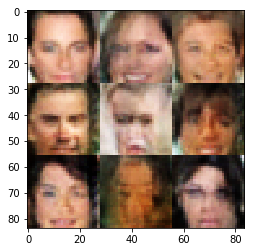

Epoch 1/1... Batch 2725... Discriminator Loss: 1.2067... Generator Loss: 0.8361
Epoch 1/1... Batch 2750... Discriminator Loss: 1.1430... Generator Loss: 0.8677
Epoch 1/1... Batch 2775... Discriminator Loss: 0.9207... Generator Loss: 1.5674
Epoch 1/1... Batch 2800... Discriminator Loss: 1.3035... Generator Loss: 0.6770


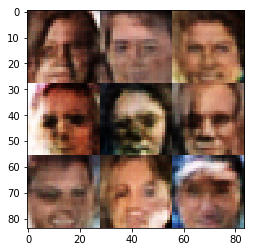

Epoch 1/1... Batch 2825... Discriminator Loss: 1.2887... Generator Loss: 0.7074
Epoch 1/1... Batch 2850... Discriminator Loss: 1.1126... Generator Loss: 0.9451
Epoch 1/1... Batch 2875... Discriminator Loss: 1.2700... Generator Loss: 1.2470
Epoch 1/1... Batch 2900... Discriminator Loss: 1.3426... Generator Loss: 0.6239


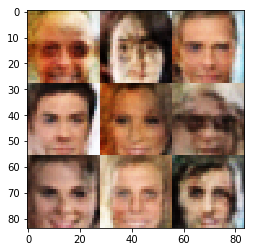

Epoch 1/1... Batch 2925... Discriminator Loss: 1.2238... Generator Loss: 0.7552
Epoch 1/1... Batch 2950... Discriminator Loss: 1.0120... Generator Loss: 1.1576
Epoch 1/1... Batch 2975... Discriminator Loss: 1.3191... Generator Loss: 0.5712
Epoch 1/1... Batch 3000... Discriminator Loss: 1.3599... Generator Loss: 0.5355


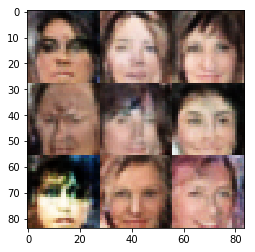

Epoch 1/1... Batch 3025... Discriminator Loss: 0.8816... Generator Loss: 1.5927
Epoch 1/1... Batch 3050... Discriminator Loss: 1.0980... Generator Loss: 0.9992
Epoch 1/1... Batch 3075... Discriminator Loss: 1.0347... Generator Loss: 1.1529
Epoch 1/1... Batch 3100... Discriminator Loss: 1.4020... Generator Loss: 0.4787


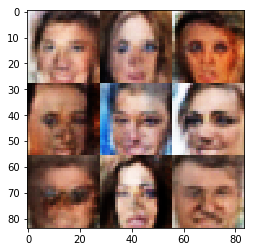

Epoch 1/1... Batch 3125... Discriminator Loss: 1.0993... Generator Loss: 0.8869
Epoch 1/1... Batch 3150... Discriminator Loss: 1.0362... Generator Loss: 0.9609


In [13]:
batch_size = 64 # not 128 due to GPU memory limitations
z_dim = 128
learning_rate = 0.00025
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.